In [81]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [82]:
def set_seed(seed=42):
    np.random.seed(seed) 
    tf.random.set_seed(seed) 
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

In [83]:
def plot_samples(generator, image_name, nrows=3, ncols=6):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))
    idx = 0

    for i in range(nrows):
        for j in range(ncols):
            label = labels[np.argmax(generator[0][1][idx])]
            ax[i, j].set_title(f"{label}")
            ax[i, j].imshow(generator[0][0][idx][:, :, :])
            ax[i, j].axis("off")
            idx += 1

    plt.tight_layout()
    plt.suptitle("Sample Training Images", fontsize=21)
    
    plt.savefig('images/' + image_name + ' - Samples.jpg', dpi=300, format='jpg')
    plt.show()

In [84]:
def plot_history(train_acc, val_acc, train_loss, val_loss, epochs, image_name):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.savefig('images/' + image_name + ' - History.jpg', dpi=300, format='jpg')
    plt.show()

In [85]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp

def plot_auc(validation_generator, y_pred_prob, image_name):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(validation_generator.classes == i, y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_macro = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    tpr_macro = np.zeros_like(fpr_macro)
    for i in range(n_classes):
        tpr_macro += interp(fpr_macro, fpr[i], tpr[i])
    tpr_macro /= n_classes
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    plt.figure(figsize=(12,10))
    lw = 2
    colors = cycle(['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot(fpr_macro, tpr_macro,
             label='macro-average ROC curve (AUC = {0:0.2f})'
             ''.format(roc_auc_macro),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    
    plt.savefig('images/' + image_name + ' - AUC.jpg', dpi=300, format='jpg')
    plt.show()

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

def plot_cm(validation_generator, y_pred, image_name):
    labels = validation_generator.class_indices.keys()
    cm = confusion_matrix(validation_generator.classes, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    plt.figure(figsize=(16, 12))
    disp.plot(cmap=plt.cm.Blues, values_format="d", xticks_rotation='vertical')
    
    plt.savefig('images/' + image_name + ' - Confustion Matrix.jpg', dpi=300, format='jpg')
    plt.show()

In [87]:
dataset_path = "/kaggle/input/parasites/"

In [88]:
images_directory = "images"
if not os.path.exists(images_directory):
    os.mkdir(images_directory)

models_directory = "models"
if not os.path.exists(models_directory):
    os.mkdir(models_directory)

## EDA

In [89]:
labels = sorted(os.listdir(dataset_path))

In [16]:
class_counts = {} 
sample_images = {} 

for label in labels:
    class_path = os.path.join(dataset_path, label)
    
    images = os.listdir(class_path)
    
    class_counts[label] = len(images)
    
    random_image = random.choice(images)
    sample_images[label] = os.path.join(class_path, random_image)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

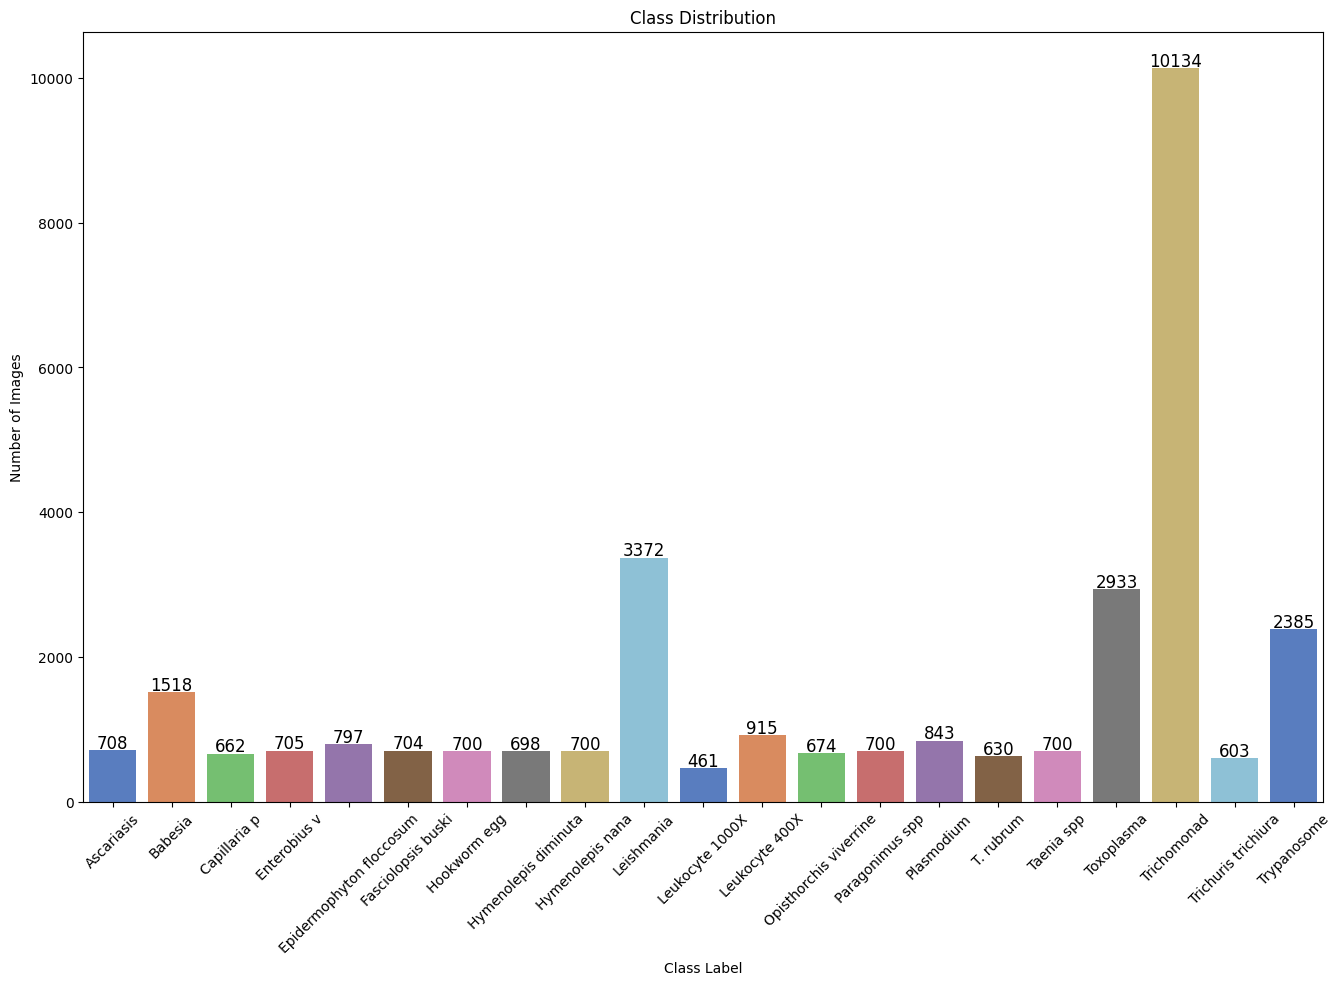

In [31]:
colors = sns.color_palette('muted')

plt.figure(figsize=(16, 10))
ax = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=colors)

for p, label in zip(ax.patches, class_counts.values()):
    ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, xytext=(0, 5), textcoords='offset points')

plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.savefig('images/[Before] Bar - Class Distribution.jpg', dpi=300, format='jpg')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


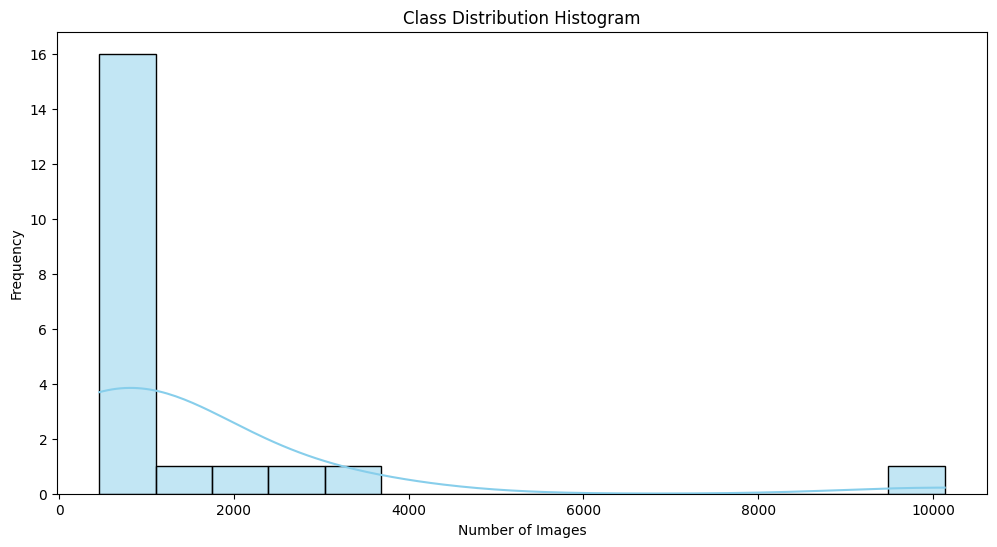

In [32]:
plt.figure(figsize=(12, 6))
sns.histplot(list(class_counts.values()), bins=15, kde=True, color='skyblue') 
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.title('Class Distribution Histogram')
plt.savefig('images/[Before] Histogram - Class Distribution.jpg', dpi=300, format='jpg')
plt.show()

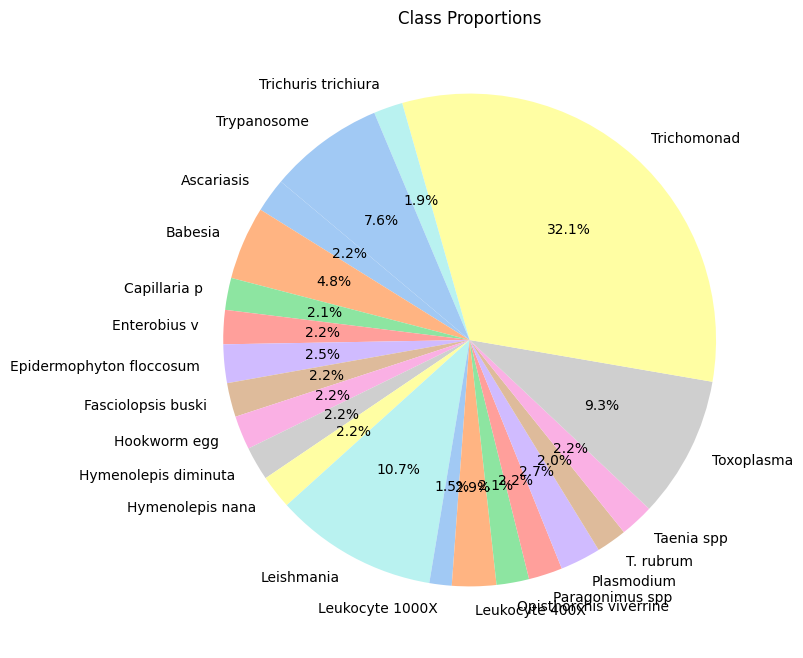

In [33]:
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Class Proportions')
plt.savefig('images/[Before] Pie - Class Proportions.jpg', dpi=300, format='jpg')
plt.show()

In [22]:
MAX_SAMPLES_PER_CLASS = 1000

downsampled_paths = []

for label in labels:
    class_path = os.path.join(dataset_path, label)
    files = os.listdir(class_path)
    np.random.shuffle(files)
    
    downsampled_paths.extend([os.path.join(class_path, file) for file in files[:MAX_SAMPLES_PER_CLASS]])

df = pd.DataFrame({"filename": downsampled_paths, "class": [os.path.basename(os.path.dirname(path)) for path in downsampled_paths]})
df.head()

filename       class
0  /kaggle/input/parasites/Parasites/Ascariasis/A...  Ascariasis
1  /kaggle/input/parasites/Parasites/Ascariasis/A...  Ascariasis
2  /kaggle/input/parasites/Parasites/Ascariasis/A...  Ascariasis
3  /kaggle/input/parasites/Parasites/Ascariasis/A...  Ascariasis
4  /kaggle/input/parasites/Parasites/Ascariasis/A...  Ascariasis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


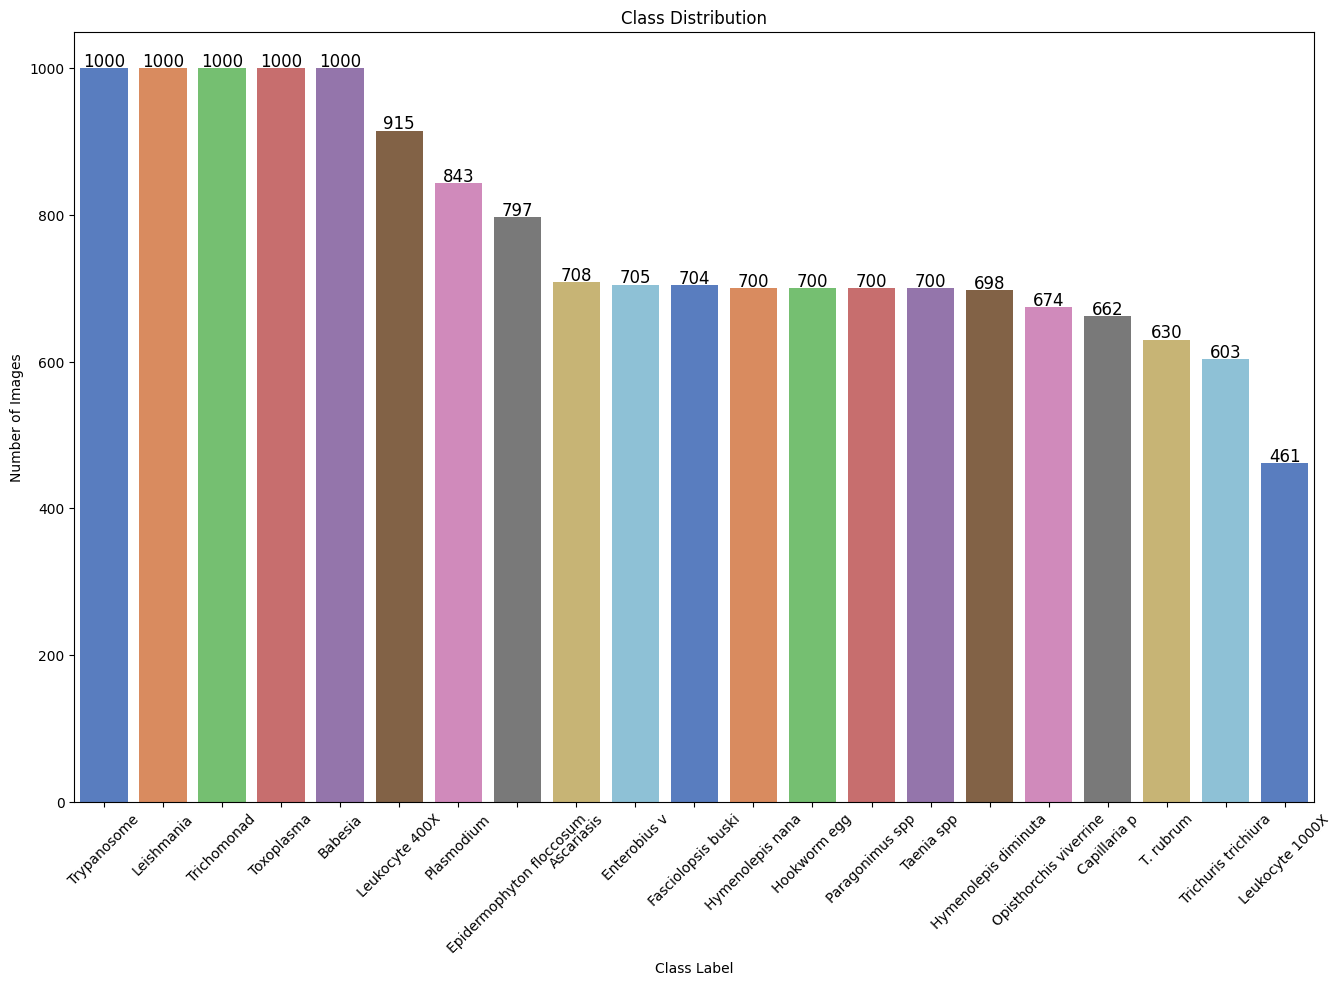

In [34]:
af_counts = df["class"].value_counts()

colors = sns.color_palette('muted')

plt.figure(figsize=(16, 10))
ax = sns.barplot(x=af_counts.index, y=af_counts, palette=colors)

for p, label in zip(ax.patches, af_counts):
    ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, xytext=(0, 5), textcoords='offset points')

plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.savefig('images/[After] Bar - Class Distribution.jpg', dpi=300, format='jpg')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


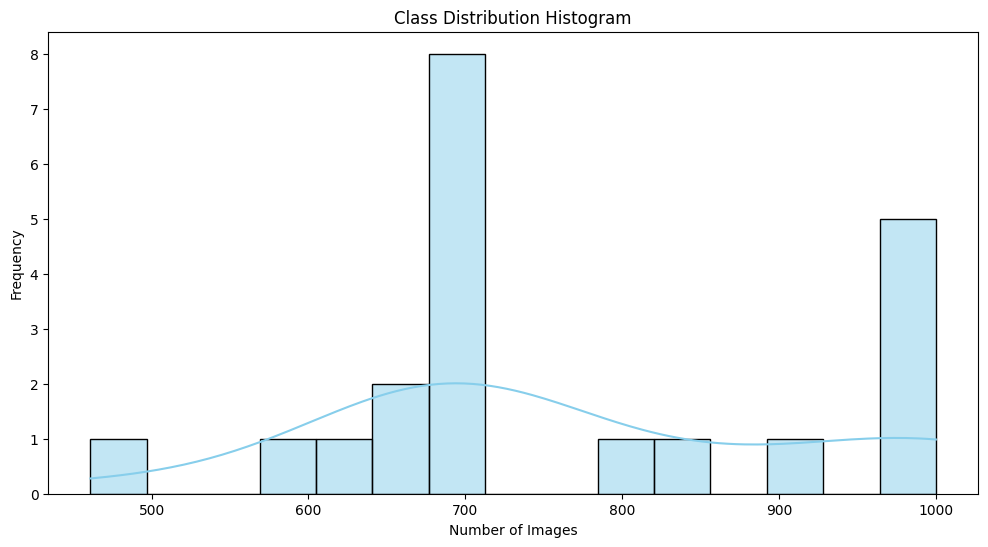

In [35]:
plt.figure(figsize=(12, 6))
sns.histplot(af_counts, bins=15, kde=True, color='skyblue') 
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.title('Class Distribution Histogram')
plt.savefig('images/[After] Histogram - Class Distribution.jpg', dpi=300, format='jpg')
plt.show()

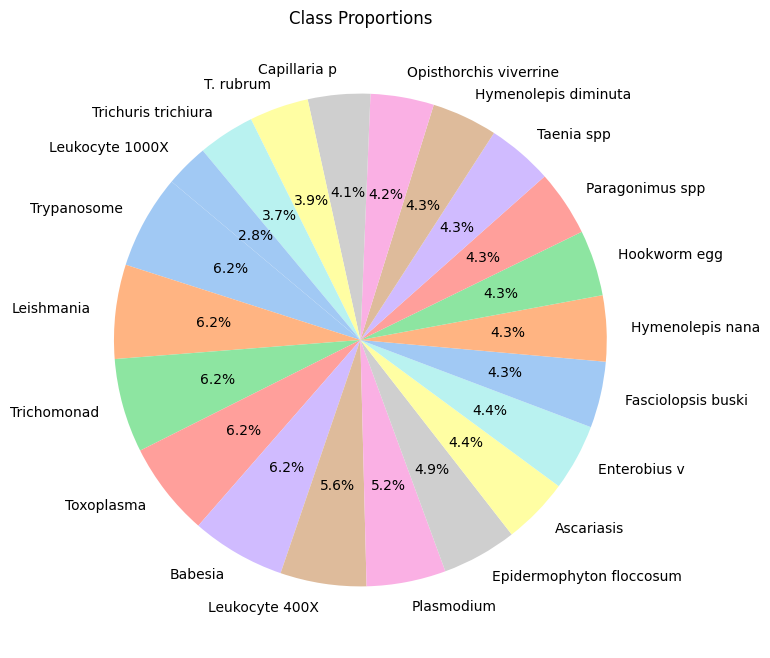

In [36]:
plt.figure(figsize=(8, 8))
plt.pie(af_counts, labels=af_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Class Proportions')
plt.savefig('images/[After] Pie - Class Proportions.jpg', dpi=300, format='jpg')
plt.show()

## Custom CNN Model

In [90]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
n_classes = 21
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [91]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

In [14]:
cnn_train_datagen = ImageDataGenerator(
    horizontal_flip=True, 
    rescale=1./255,
    validation_split=0.2
)

cnn_train_generator = cnn_train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 12965 images belonging to 21 classes.


In [15]:
cnn_validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

cnn_validation_generator = cnn_validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 3235 images belonging to 21 classes.


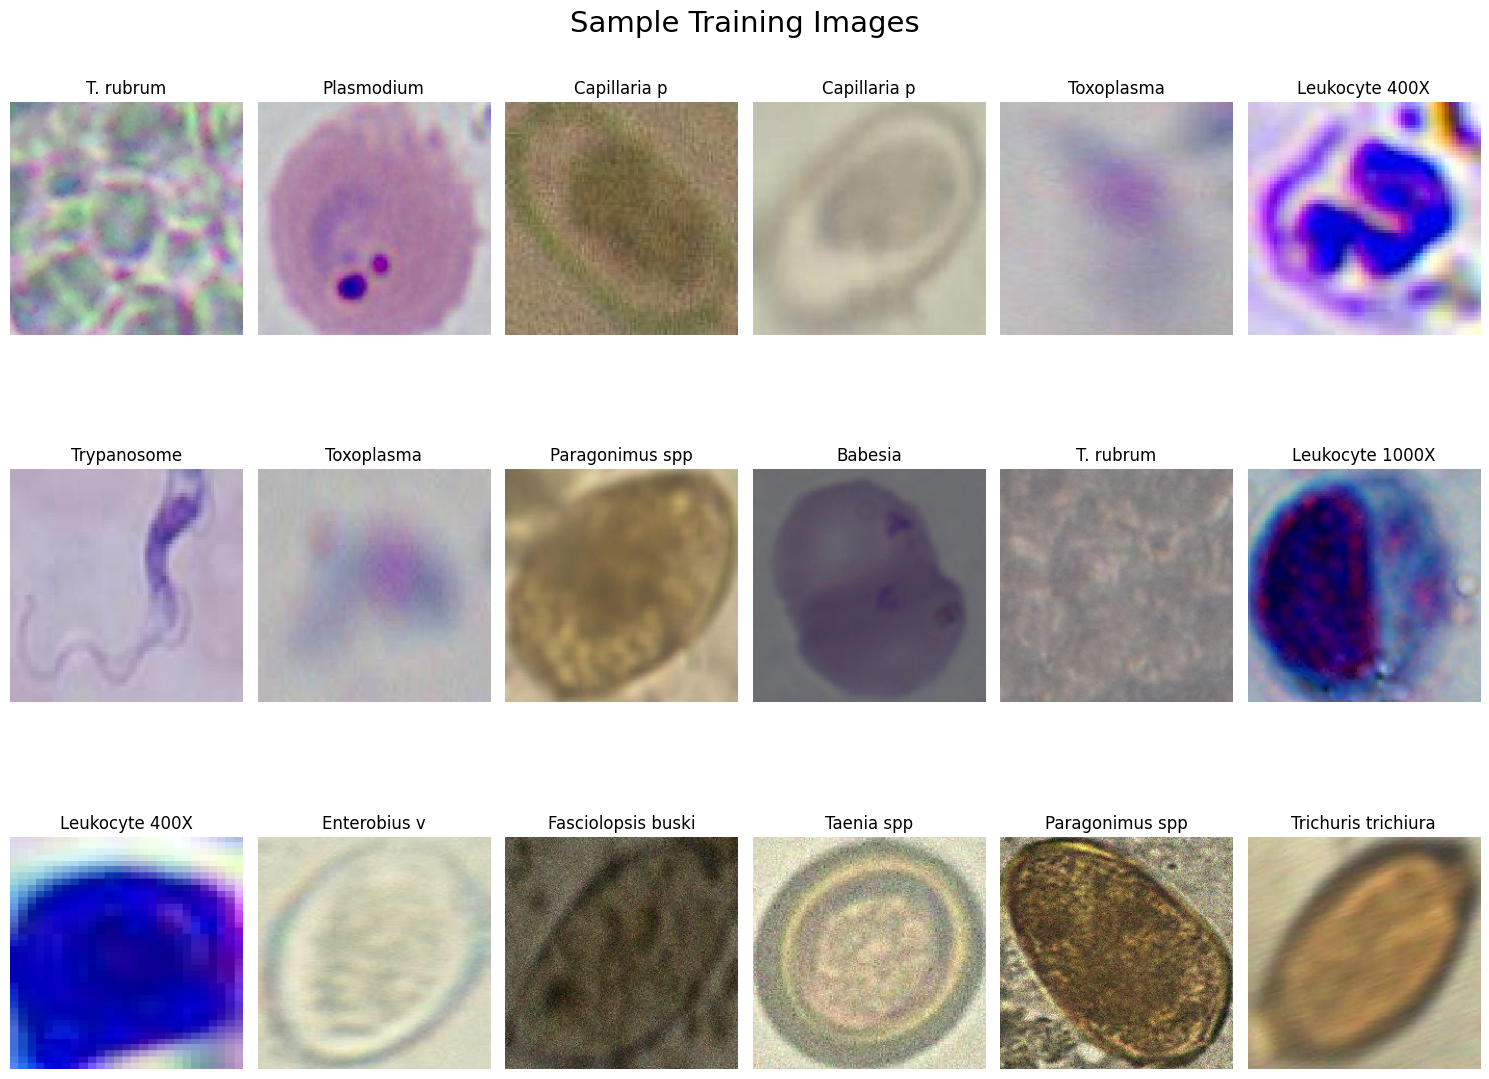

In [38]:
plot_samples(cnn_train_generator, "Custom CNN")

In [17]:
cnn_model = Sequential([
    Conv2D(
        filters=192,
        kernel_size=(3,3), 
        strides=(1,1), 
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    Dropout(0.3),
    
    Dense(n_classes, activation='softmax')
])

In [18]:
cnn_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 192)     5376      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 192)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     221312    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

In [20]:
cnn_history = cnn_model.fit(
    cnn_train_generator, 
    epochs=10, 
    validation_data=cnn_validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
406/406 [==============================] - 153s 349ms/step - loss: 2.1060 - accuracy: 0.2811 - val_loss: 1.5755 - val_accuracy: 0.4903 - lr: 0.0010
Epoch 2/10
406/406 [==============================] - 112s 275ms/step - loss: 1.3352 - accuracy: 0.5368 - val_loss: 1.0720 - val_accuracy: 0.6563 - lr: 0.0010
Epoch 3/10
406/406 [==============================] - 116s 285ms/step - loss: 1.0505 - accuracy: 0.6309 - val_loss: 0.8399 - val_accuracy: 0.7051 - lr: 0.0010
Epoch 4/10
406/406 [==============================] - 111s 275ms/step - loss: 0.9091 - accuracy: 0.6887 - val_loss: 0.9627 - val_accuracy: 0.6615 - lr: 0.0010
Epoch 5/10
406/406 [==============================] - 112s 275ms/step - loss: 0.8268 - accuracy: 0.7199 - val_loss: 0.7300 - val_accuracy: 0.7496 - lr: 0.0010
Epoch 6/10
406/406 [==============================] - 112s 275ms/step - loss: 0.7468 - accuracy: 0.7455 - val_loss: 0.7829 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 7/10
406/406 [==========================

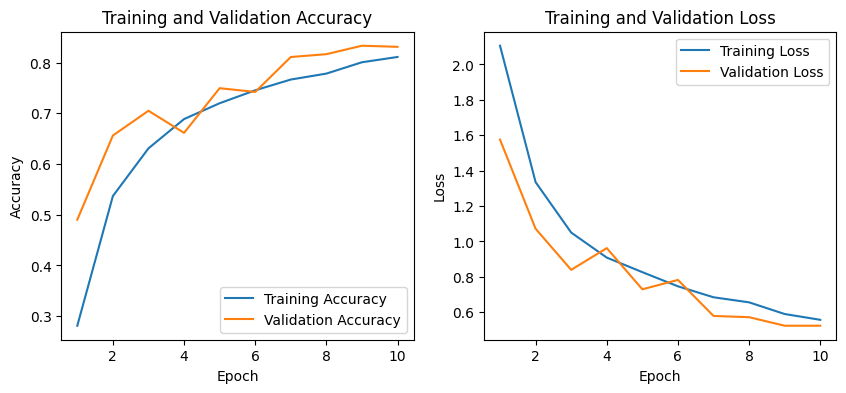

In [39]:
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
epochs = range(1, len(loss) + 1)
    
plot_history(acc, val_acc, loss, val_loss, epochs, "Custom CNN")

In [26]:
score = cnn_model.evaluate(cnn_validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3235/3235 [==============================] - 21s 7ms/step - loss: 0.5242 - accuracy: 0.8312
Test loss: 0.524182915687561
Test accuracy: 0.8312210440635681


In [27]:
predict = cnn_model.predict(cnn_validation_generator)
# predict the class label
y_classes = predict.argmax(axis=-1)
y_classes

3235/3235 [==============================] - 16s 5ms/step


array([ 7,  0, 13, ..., 20, 20, 20])

<Figure size 1600x1200 with 0 Axes>

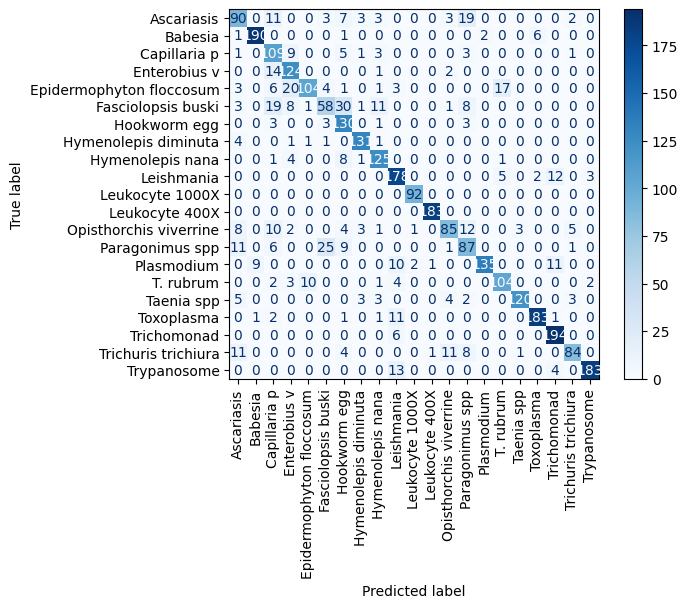

In [40]:
plot_cm(cnn_validation_generator, y_classes, "Custom CNN")

In [42]:
print(classification_report(cnn_validation_generator.classes, y_classes))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       141
           1       0.95      0.95      0.95       200
           2       0.60      0.83      0.69       132
           3       0.73      0.88      0.79       141
           4       0.90      0.65      0.76       159
           5       0.62      0.41      0.50       140
           6       0.65      0.93      0.76       140
           7       0.92      0.94      0.93       139
           8       0.82      0.89      0.86       140
           9       0.79      0.89      0.84       200
          10       0.97      1.00      0.98        92
          11       0.99      1.00      0.99       183
          12       0.79      0.63      0.71       134
          13       0.61      0.62      0.62       140
          14       0.99      0.80      0.89       168
          15       0.82      0.83      0.82       126
          16       0.97      0.86      0.91       140
          17       0.96    

3235/3235 [==============================] - 16s 5ms/step


/tmp/ipykernel_42/3810898940.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr_macro += interp(fpr_macro, fpr[i], tpr[i])


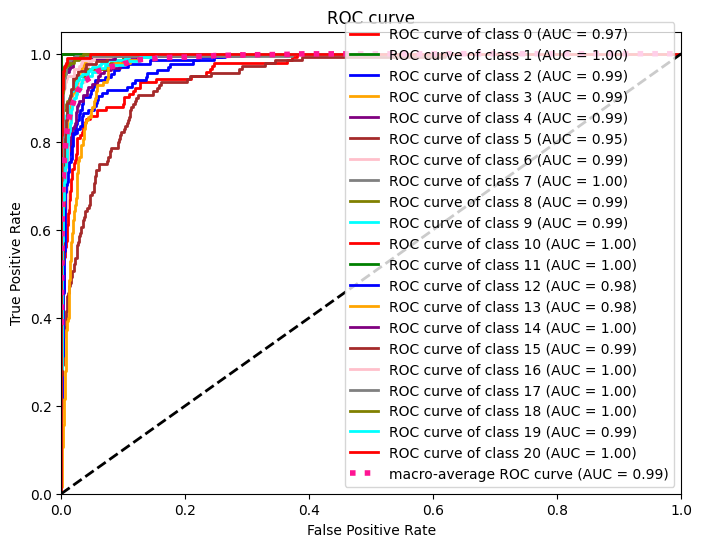

In [55]:
plot_auc(cnn_validation_generator, predict, "Custom CNN")

In [54]:
cnn_model.save('models/cnn_custom_83%.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


-----------------------

## ResNet50

In [43]:
resnet50_train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True,
    validation_split=0.2
)

resnet50_train_generator = resnet50_train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 12965 images belonging to 21 classes.


In [14]:
resnet50_validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

resnet50_validation_generator = resnet50_validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 3235 images belonging to 21 classes.


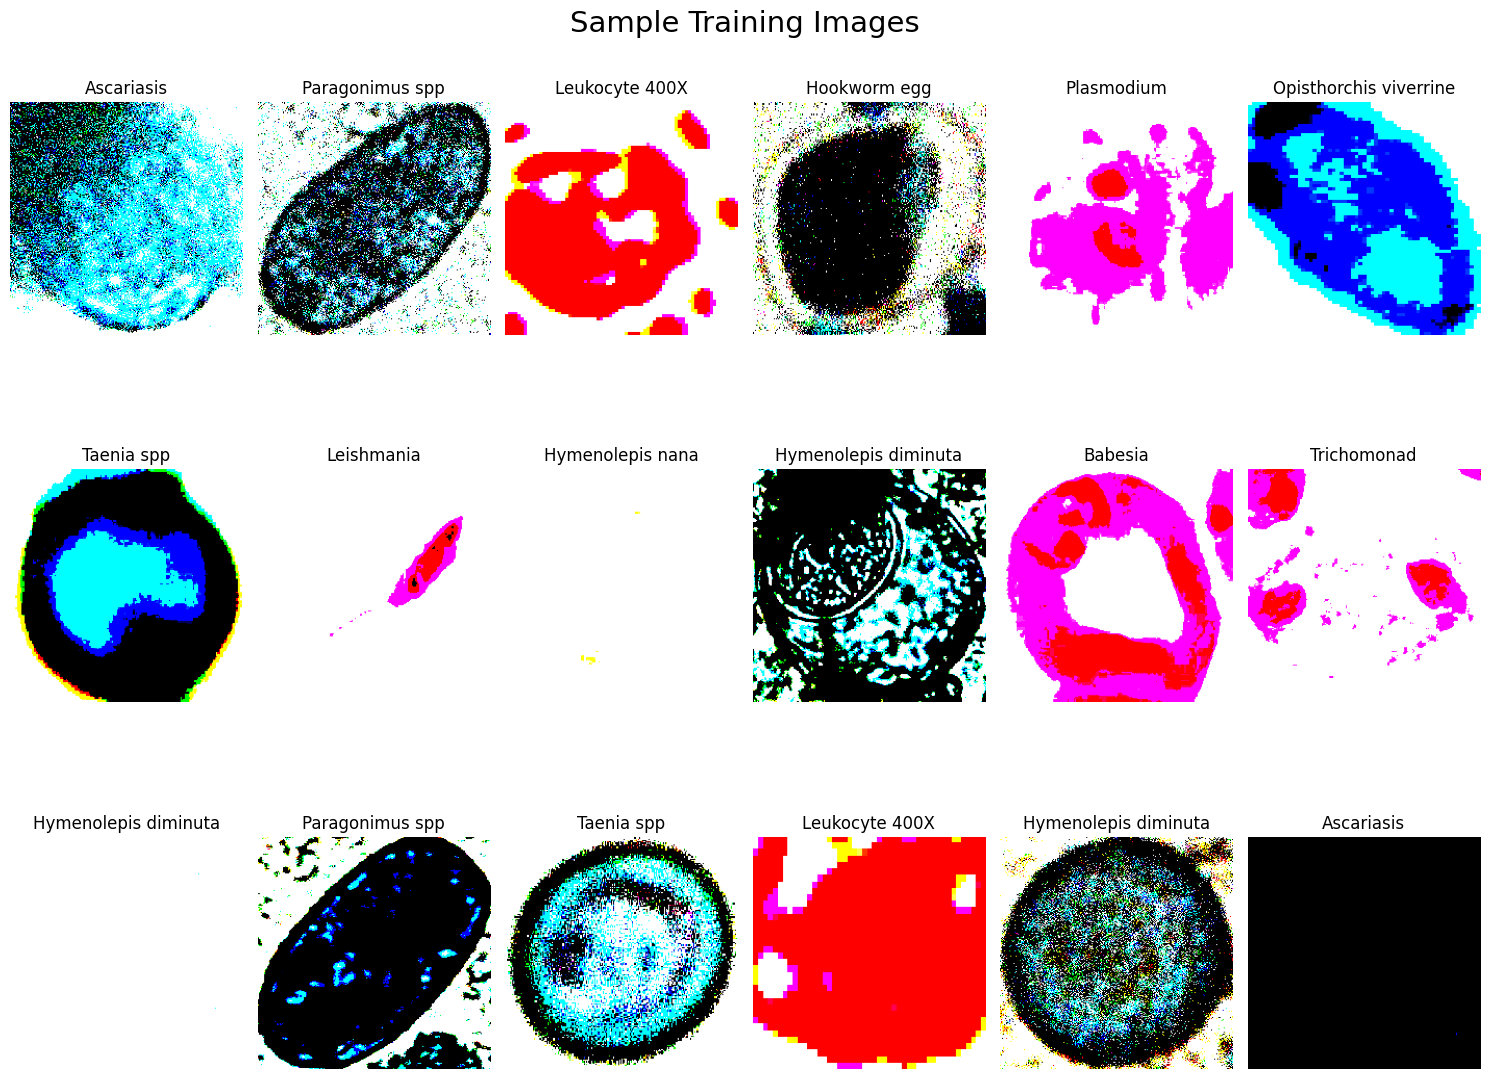

In [46]:
plot_samples(resnet50_train_generator, "ResNet50")

In [16]:
from tensorflow.keras.applications.resnet import ResNet50

resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in resnet50.layers:
    layer.trainable = False

resnet50_model = Sequential([
    resnet50,
    
    GlobalAveragePooling2D(),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(n_classes, activation='softmax')
])

94765736/94765736 [==============================] - 0s 0us/step


In [17]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [19]:
resnet50_history = resnet50_model.fit(
    resnet50_train_generator,
    epochs=10,
    validation_data=resnet50_validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
406/406 [==============================] - 206s 481ms/step - loss: 0.9867 - accuracy: 0.6823 - val_loss: 0.4364 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 2/10
406/406 [==============================] - 104s 256ms/step - loss: 0.4826 - accuracy: 0.8368 - val_loss: 0.3770 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 3/10
406/406 [==============================] - 103s 254ms/step - loss: 0.3916 - accuracy: 0.8655 - val_loss: 0.3029 - val_accuracy: 0.8974 - lr: 0.0010
Epoch 4/10
406/406 [==============================] - 102s 251ms/step - loss: 0.3195 - accuracy: 0.8943 - val_loss: 0.3417 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 5/10
406/406 [==============================] - 105s 259ms/step - loss: 0.3018 - accuracy: 0.8987 - val_loss: 0.2662 - val_accuracy: 0.9134 - lr: 0.0010
Epoch 6/10
406/406 [==============================] - 103s 254ms/step - loss: 0.2528 - accuracy: 0.9158 - val_loss: 0.2521 - val_accuracy: 0.9168 - lr: 0.0010
Epoch 7/10
406/406 [==========================

In [20]:
score = resnet50_model.evaluate(resnet50_validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3235/3235 [==============================] - 37s 11ms/step - loss: 0.2296 - accuracy: 0.9274
Test loss: 0.2295619249343872
Test accuracy: 0.927357017993927


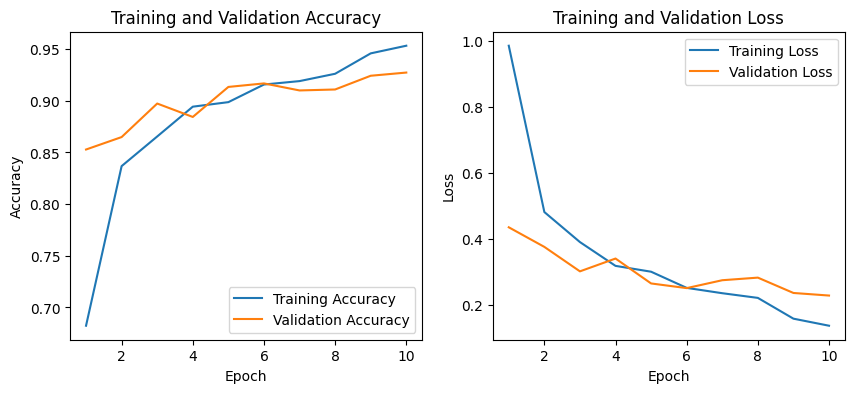

In [21]:
acc = resnet50_history.history['accuracy']
val_acc = resnet50_history.history['val_accuracy']
loss = resnet50_history.history['loss']
val_loss = resnet50_history.history['val_loss']
epochs = range(1, len(loss) + 1)

plot_history(acc, val_acc, loss, val_loss, epochs, "ResNet50")

In [27]:
predict = resnet50_model.predict(resnet50_validation_generator)
# predict the class label
y_classes = predict.argmax(axis=-1)
y_classes

3235/3235 [==============================] - 32s 10ms/step


array([ 0,  0,  0, ..., 20, 20, 20])

<Figure size 1600x1200 with 0 Axes>

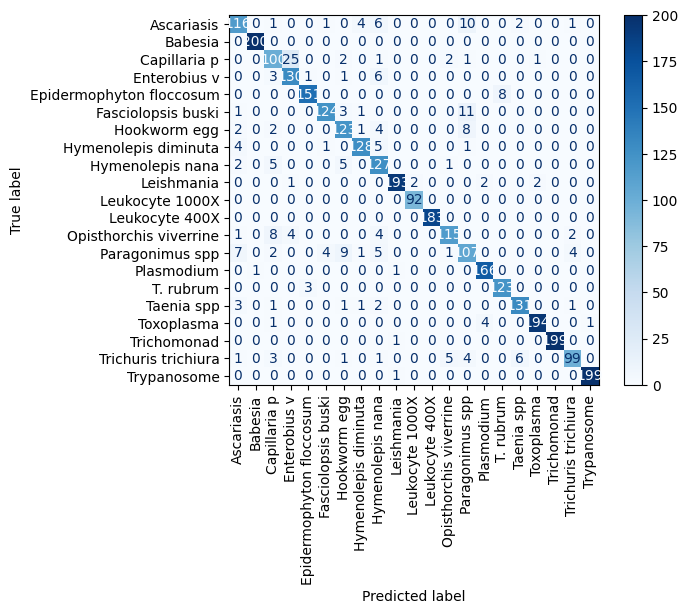

In [28]:
plot_cm(resnet50_validation_generator, y_classes, "ResNet50")

In [29]:
print(classification_report(resnet50_validation_generator.classes, y_classes))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       141
           1       1.00      1.00      1.00       200
           2       0.79      0.76      0.78       132
           3       0.81      0.92      0.86       141
           4       0.97      0.95      0.96       159
           5       0.95      0.89      0.92       140
           6       0.85      0.88      0.86       140
           7       0.94      0.92      0.93       139
           8       0.79      0.91      0.84       140
           9       0.98      0.96      0.97       200
          10       0.98      1.00      0.99        92
          11       1.00      1.00      1.00       183
          12       0.93      0.86      0.89       134
          13       0.75      0.76      0.76       140
          14       0.97      0.99      0.98       168
          15       0.94      0.98      0.96       126
          16       0.94      0.94      0.94       140
          17       0.98    

/tmp/ipykernel_42/1904538741.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr_macro += interp(fpr_macro, fpr[i], tpr[i])


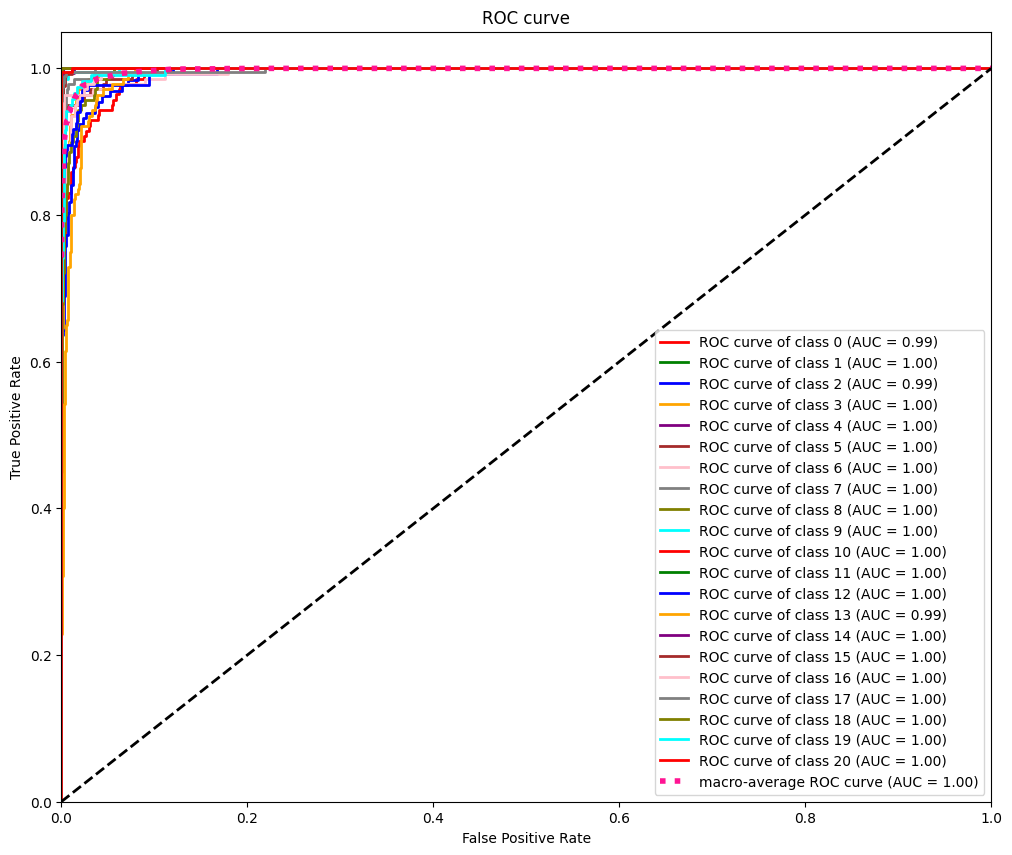

In [30]:
plot_auc(resnet50_validation_generator, predict, "ResNet50")

In [31]:
resnet50_model.save('models/resnet50_93%.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


-------------

## ResNet50V2

In [35]:
resnet50v2_train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
    horizontal_flip=True,
    validation_split=0.2
)

resnet50v2_train_generator = resnet50v2_train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 12965 images belonging to 21 classes.


In [34]:
resnet50v2_validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
    validation_split=0.2
)

resnet50v2_validation_generator = resnet50v2_validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 3235 images belonging to 21 classes.


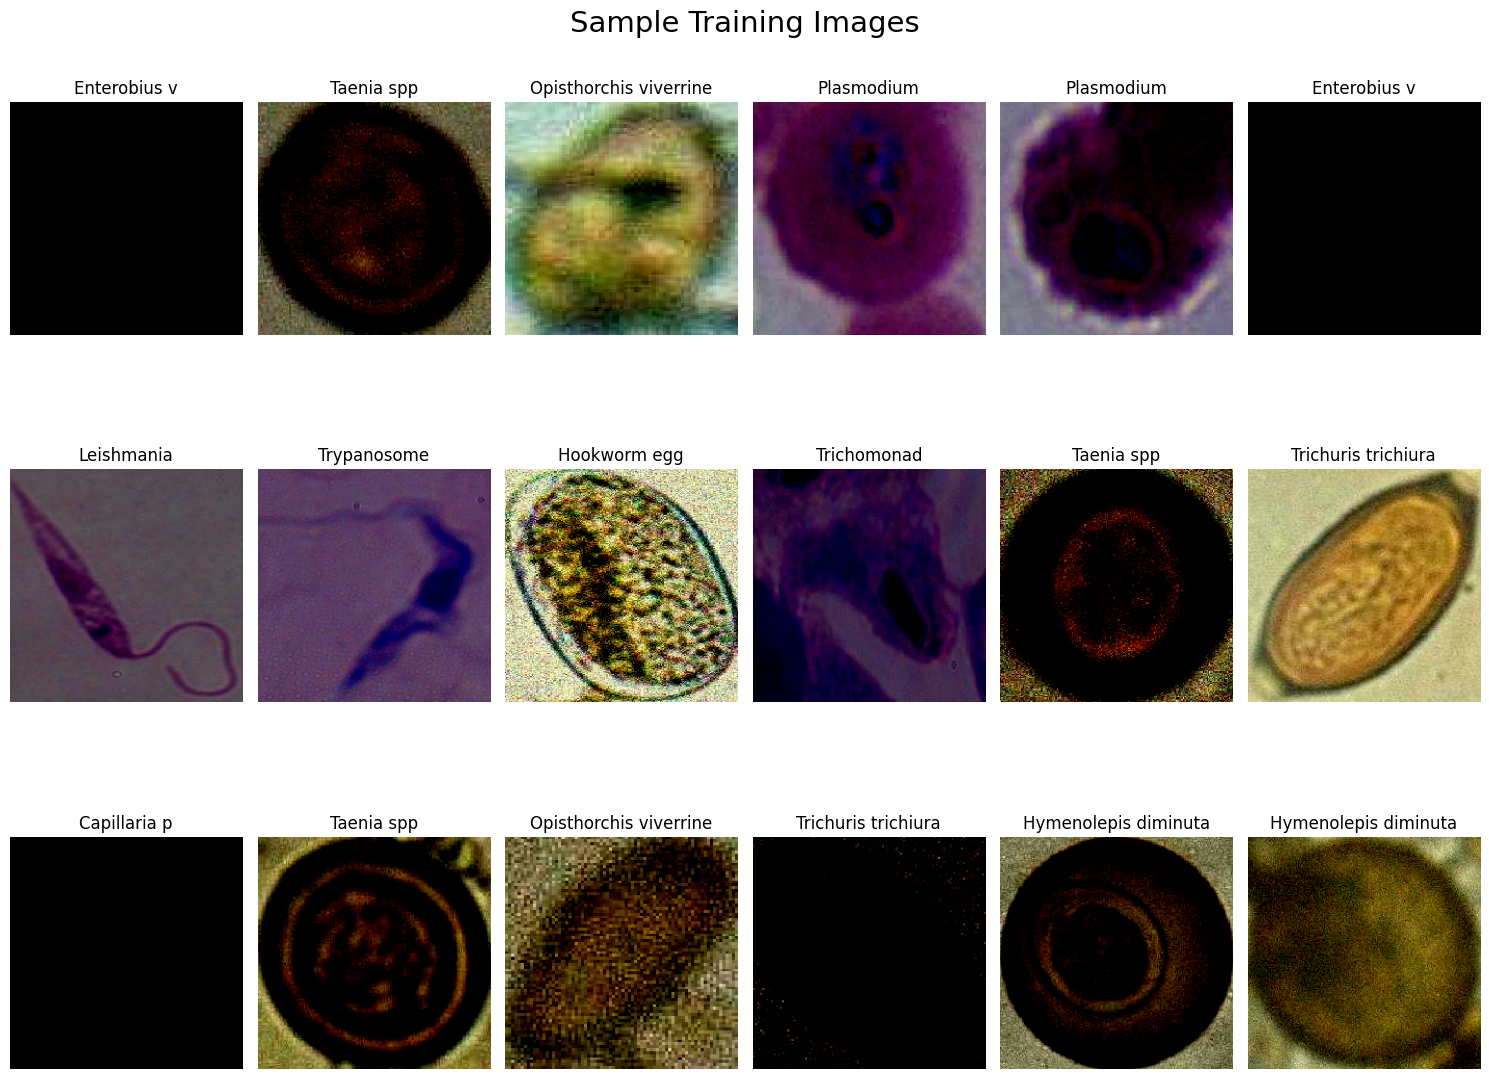

In [47]:
plot_samples(resnet50v2_train_generator, "ResNet50V2")

In [48]:
from tensorflow.keras.applications import ResNet50V2

resnet50v2 = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
)

for layer in resnet50v2.layers:
        layer.trainable=False

resnet50v2_model = Sequential([
    resnet50v2,
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    Dropout(0.3),
    
    Dense(21, activation='softmax')
])

94668760/94668760 [==============================] - 1s 0us/step


In [49]:
resnet50v2_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
resnet50v2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 512)               51380736  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 21)               

In [51]:
resnet50v2_history = resnet50v2_model.fit(
    resnet50v2_train_generator, 
    epochs=10, 
    validation_data=resnet50v2_validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
406/406 [==============================] - 108s 256ms/step - loss: 2.5628 - accuracy: 0.5924 - val_loss: 0.8909 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 2/10
406/406 [==============================] - 103s 254ms/step - loss: 1.3636 - accuracy: 0.6906 - val_loss: 0.8305 - val_accuracy: 0.7920 - lr: 0.0010
Epoch 3/10
406/406 [==============================] - 101s 249ms/step - loss: 1.1894 - accuracy: 0.7391 - val_loss: 0.7525 - val_accuracy: 0.8037 - lr: 0.0010
Epoch 4/10
406/406 [==============================] - 102s 250ms/step - loss: 0.9795 - accuracy: 0.7630 - val_loss: 0.5467 - val_accuracy: 0.8578 - lr: 0.0010
Epoch 5/10
406/406 [==============================] - 102s 252ms/step - loss: 0.9027 - accuracy: 0.7865 - val_loss: 0.5130 - val_accuracy: 0.8686 - lr: 0.0010
Epoch 6/10
406/406 [==============================] - 101s 248ms/step - loss: 0.7775 - accuracy: 0.8112 - val_loss: 0.5059 - val_accuracy: 0.8606 - lr: 0.0010
Epoch 7/10
406/406 [==========================

In [57]:
score = resnet50v2_model.evaluate(resnet50v2_validation_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4152938425540924
Test accuracy: 0.901081919670105


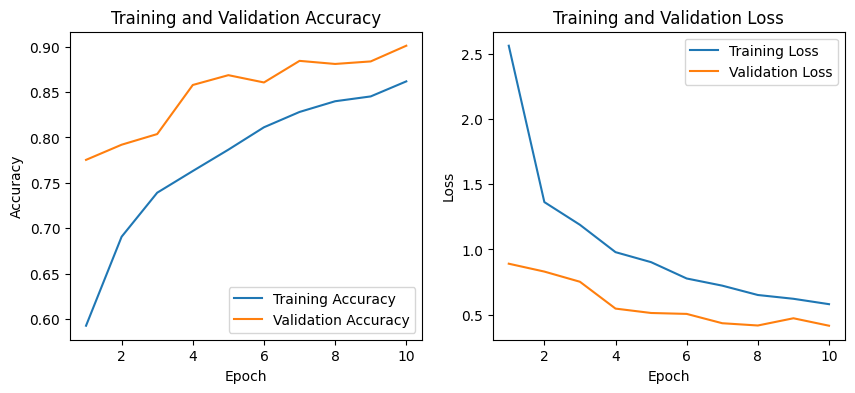

In [58]:
acc = resnet50v2_history.history['accuracy']
val_acc = resnet50v2_history.history['val_accuracy']
loss = resnet50v2_history.history['loss']
val_loss = resnet50v2_history.history['val_loss']
epochs = range(1, len(loss) + 1)

plot_history(acc, val_acc, loss, val_loss, epochs, "ResNet50V2")

In [59]:
predict = resnet50v2_model.predict(resnet50v2_validation_generator)
# predict the class label
y_classes = predict.argmax(axis=-1)
y_classes

3235/3235 [==============================] - 34s 10ms/step


array([ 0,  0,  0, ..., 20, 20, 20])

<Figure size 1600x1200 with 0 Axes>

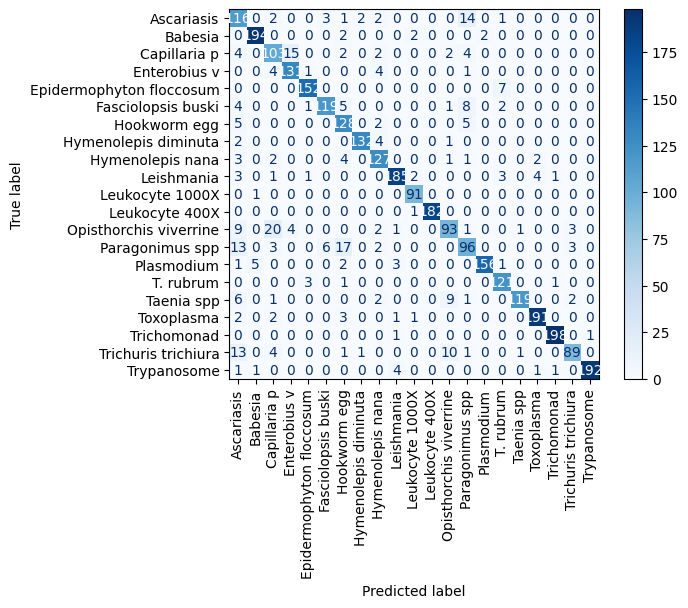

In [62]:
plot_cm(resnet50v2_validation_generator, y_classes, "ResNet50V2")

In [64]:
print(classification_report(resnet50v2_validation_generator.classes, y_classes))

              precision    recall  f1-score   support

           0       0.64      0.82      0.72       141
           1       0.97      0.97      0.97       200
           2       0.73      0.78      0.75       132
           3       0.87      0.93      0.90       141
           4       0.96      0.96      0.96       159
           5       0.93      0.85      0.89       140
           6       0.77      0.91      0.84       140
           7       0.98      0.95      0.96       139
           8       0.86      0.91      0.89       140
           9       0.95      0.93      0.94       200
          10       0.94      0.99      0.96        92
          11       1.00      0.99      1.00       183
          12       0.79      0.69      0.74       134
          13       0.73      0.69      0.71       140
          14       0.99      0.93      0.96       168
          15       0.90      0.96      0.93       126
          16       0.98      0.85      0.91       140
          17       0.96    

/tmp/ipykernel_42/1904538741.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr_macro += interp(fpr_macro, fpr[i], tpr[i])


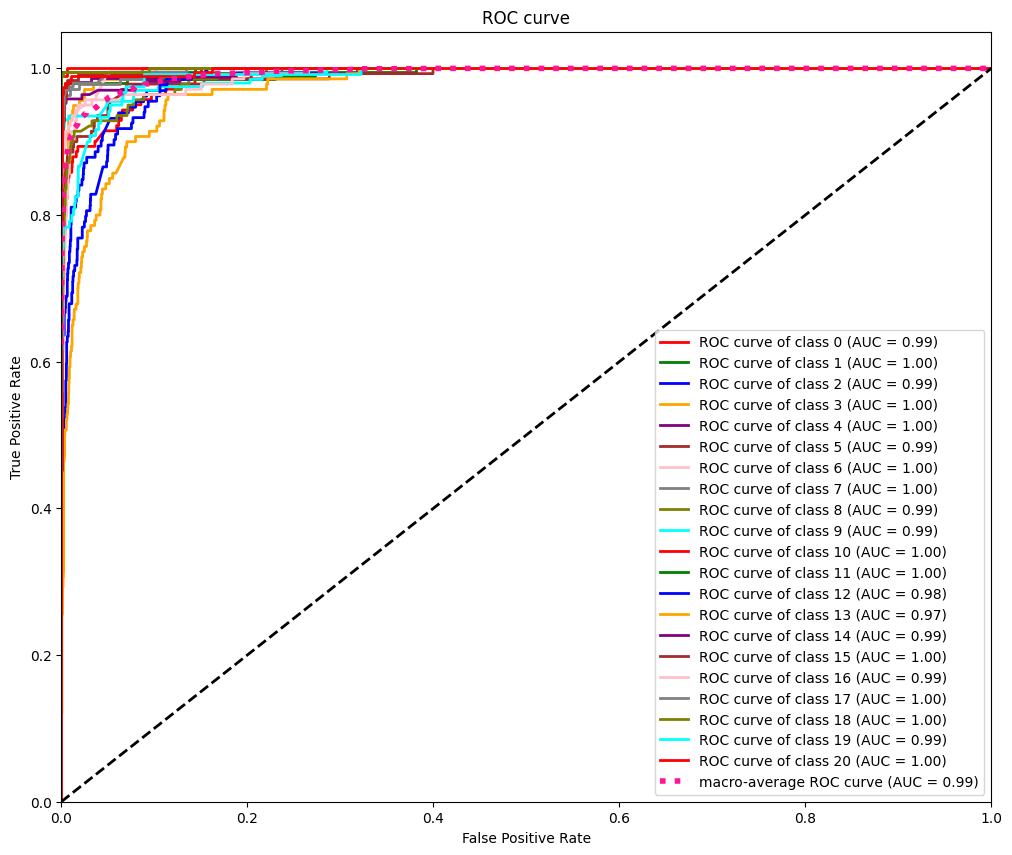

In [66]:
plot_auc(resnet50v2_validation_generator, predict, "ResNet50V2")

In [67]:
resnet50_model.save('models/resnet50v2_90%.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Xception

In [92]:
xceotion_train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    horizontal_flip=True,
    validation_split=0.2
)

xception_train_generator = xceotion_train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 12965 images belonging to 21 classes.


In [93]:
xception_validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    validation_split=0.2
)

xception_validation_generator = xception_validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 3235 images belonging to 21 classes.


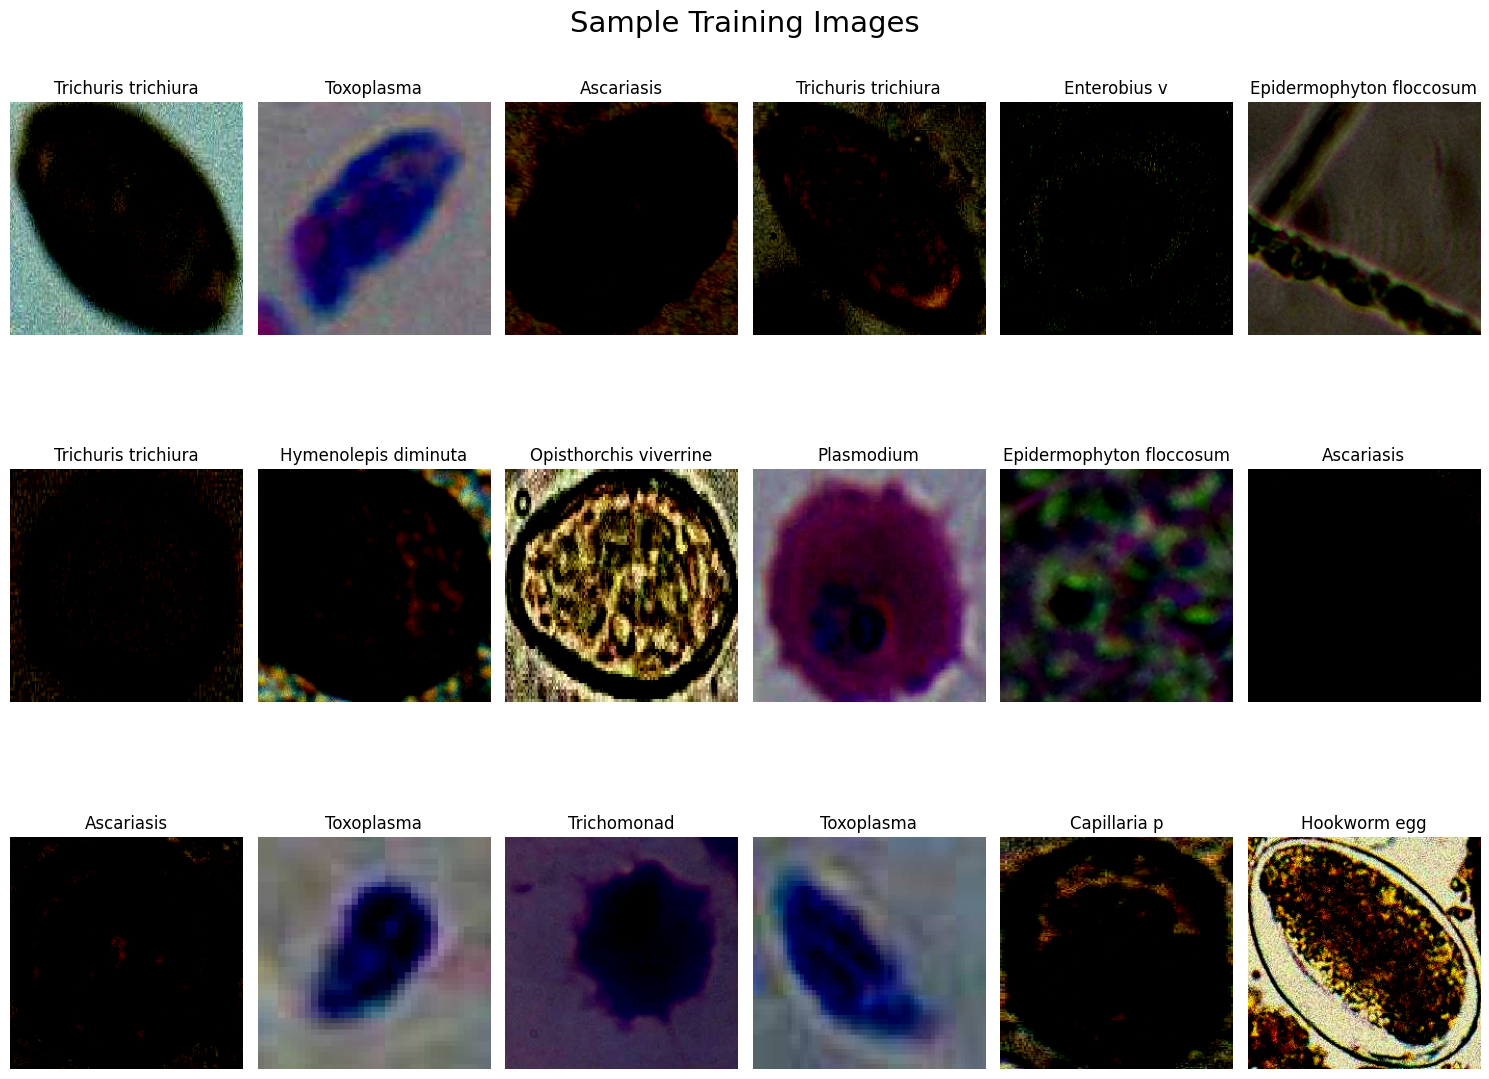

In [94]:
plot_samples(xception_train_generator, "Xception")

In [95]:
from tensorflow.keras.applications.xception import Xception

xception = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in xception.layers:
    layer.trainable = False

xception_model = Sequential([
    xception,
    
    GlobalAveragePooling2D(),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(n_classes, activation='softmax')
])

In [96]:
xception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [97]:
xception_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 256)               524544    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                      

In [98]:
xception_history = xception_model.fit(
    xception_train_generator,
    epochs=10,
    validation_data=xception_validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
406/406 [==============================] - 119s 286ms/step - loss: 1.0103 - accuracy: 0.6855 - val_loss: 0.4531 - val_accuracy: 0.8522 - lr: 0.0010
Epoch 2/10
406/406 [==============================] - 112s 275ms/step - loss: 0.4799 - accuracy: 0.8474 - val_loss: 0.4450 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 3/10
406/406 [==============================] - 123s 303ms/step - loss: 0.3984 - accuracy: 0.8666 - val_loss: 0.3633 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 4/10
406/406 [==============================] - 111s 274ms/step - loss: 0.3367 - accuracy: 0.8889 - val_loss: 0.3365 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 5/10
406/406 [==============================] - 111s 274ms/step - loss: 0.2975 - accuracy: 0.8987 - val_loss: 0.3165 - val_accuracy: 0.8952 - lr: 0.0010
Epoch 6/10
406/406 [==============================] - 111s 273ms/step - loss: 0.2775 - accuracy: 0.9075 - val_loss: 0.3195 - val_accuracy: 0.8934 - lr: 0.0010
Epoch 7/10
406/406 [==========================

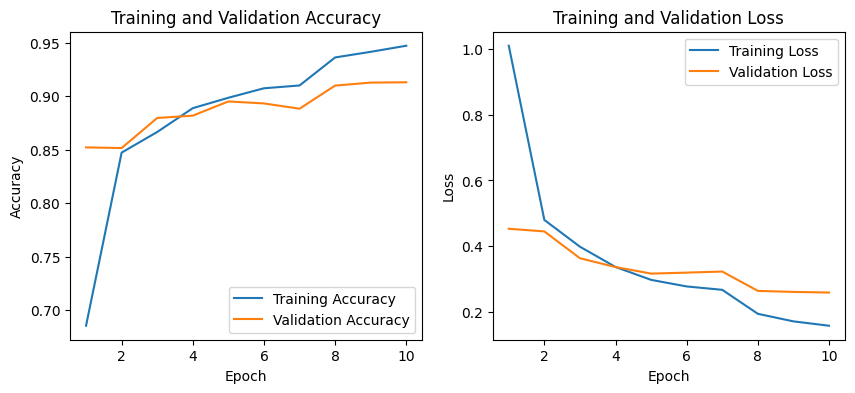

In [99]:
acc = xception_history.history['accuracy']
val_acc = xception_history.history['val_accuracy']
loss = xception_history.history['loss']
val_loss = xception_history.history['val_loss']
epochs = range(1, len(loss) + 1)

plot_history(acc, val_acc, loss, val_loss, epochs, "Xception")

In [100]:
score = xception_model.evaluate(xception_validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3235/3235 [==============================] - 33s 10ms/step - loss: 0.2589 - accuracy: 0.9131
Test loss: 0.25891634821891785
Test accuracy: 0.9131375551223755


In [101]:
predict = xception_model.predict(xception_validation_generator)
# predict the class label
y_classes = predict.argmax(axis=-1)
y_classes

3235/3235 [==============================] - 29s 9ms/step


array([ 0, 13,  0, ..., 20, 20, 20])

<Figure size 1600x1200 with 0 Axes>

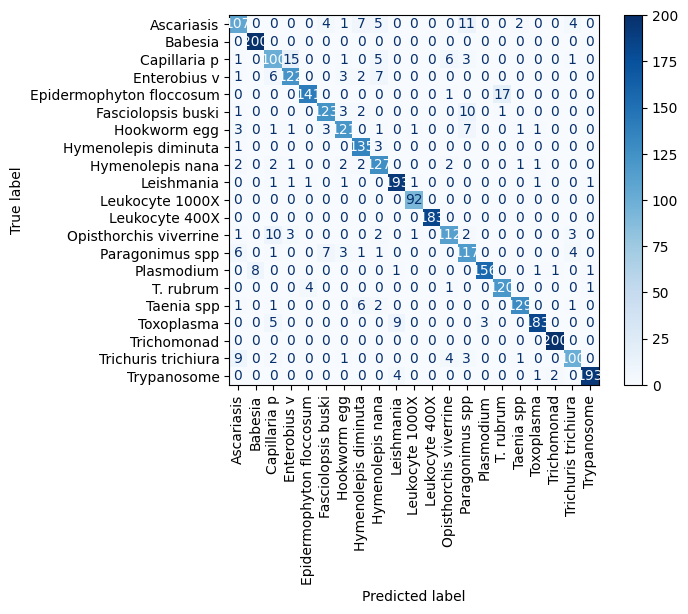

In [102]:
plot_cm(xception_validation_generator, y_classes, "Xception")

In [103]:
print(classification_report(xception_validation_generator.classes, y_classes))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       141
           1       0.96      1.00      0.98       200
           2       0.78      0.76      0.77       132
           3       0.85      0.87      0.86       141
           4       0.97      0.89      0.92       159
           5       0.90      0.88      0.89       140
           6       0.89      0.86      0.88       140
           7       0.87      0.97      0.92       139
           8       0.83      0.91      0.87       140
           9       0.93      0.96      0.95       200
          10       0.97      1.00      0.98        92
          11       1.00      1.00      1.00       183
          12       0.89      0.84      0.86       134
          13       0.76      0.84      0.80       140
          14       0.98      0.93      0.95       168
          15       0.87      0.95      0.91       126
          16       0.96      0.92      0.94       140
          17       0.97    

/tmp/ipykernel_42/1904538741.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr_macro += interp(fpr_macro, fpr[i], tpr[i])


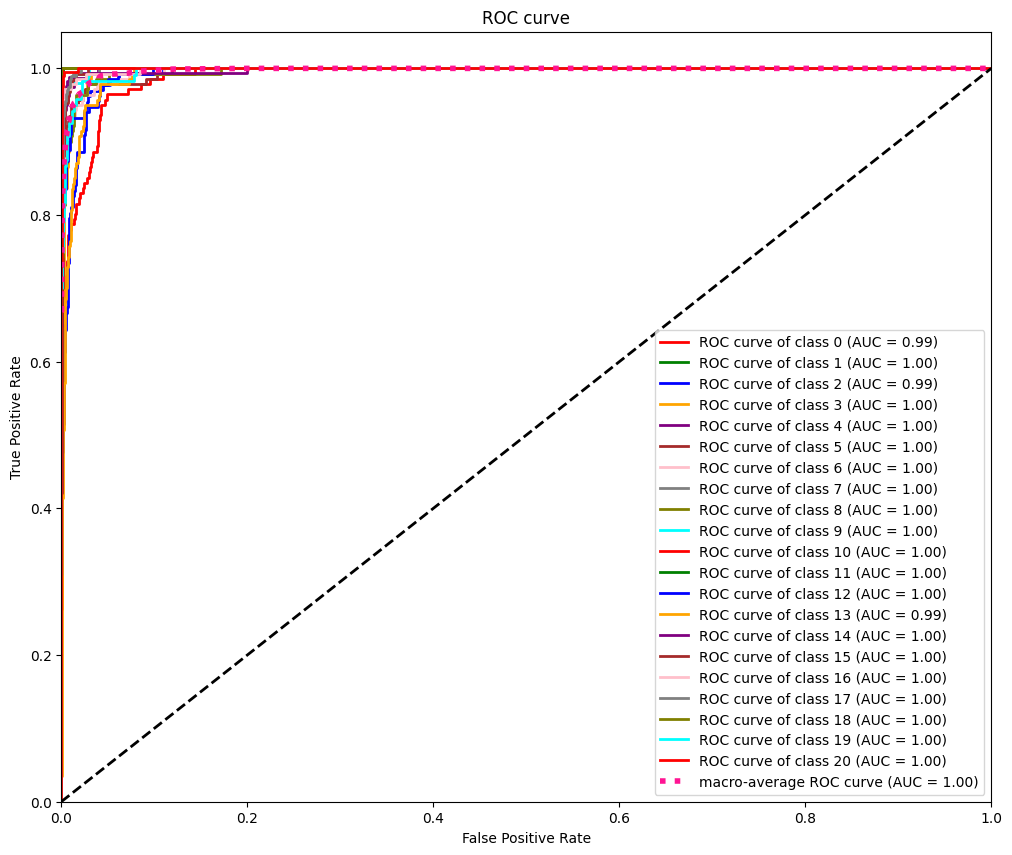

In [104]:
plot_auc(xception_validation_generator, predict, "Xception")

In [105]:
resnet50_model.save('models/xception_91%.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
